In [1]:
import pytest
import torch

In [2]:
import sys
sys.path.insert(0, '../tests/')

In [3]:
from conftest import *
from pathlib import Path

paths = dict(data = Path('../data/'))

device = 'cuda:0'

use_cuda = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%matplotlib inline

# Set up models

In [6]:
slen = 30
tile_slen = 5

In [7]:
decoder_setup = DecoderSetup(paths, device)

In [8]:
psf_params = decoder_setup.get_fitted_psf_params()
batch_size = 128 if use_cuda else 1
n_images = 1280 if use_cuda else 1

In [9]:
star_dataset = decoder_setup.get_star_dataset(
        psf_params, n_bands=1, 
        slen=slen, tile_slen = tile_slen, 
        max_sources_per_tile=2,
        min_sources_per_tile=0,
        # this is so that the avg. number of sources 
        # a 30 x 30 image is 3
        mean_sources_per_tile=0.0833,
        batch_size=batch_size, n_images=n_images
    )


In [10]:
params = star_dataset.get_batch()

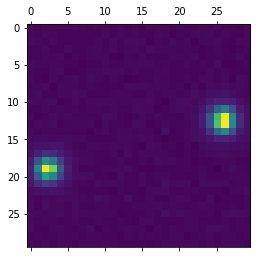

In [11]:
plt.matshow(params['images'].detach().cpu()[0, 0])

In [12]:
params['n_sources'].float().mean()

tensor(0.0809, device='cuda:0')

# set up encoder and train

In [13]:
encoder_setup = EncoderSetup(gpus = 1, device = device)

In [14]:
n_epochs = 100 if use_cuda else 1
trained_encoder = encoder_setup.get_trained_encoder(star_dataset, 
                                                    n_epochs=n_epochs, 
                                                    ptile_slen=star_dataset.tile_slen,
                                                    tile_slen=star_dataset.tile_slen,
                                                    max_detections=star_dataset.max_sources_per_tile
                                                   )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 22 K  
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1: : 10it [00:00, 25.52it/s, loss=2.988]
Epoch 1: : 15it [00:00, 31.62it/s, loss=2.988]
Epoch 1: : 20it [00:00, 35.82it/s, loss=2.988]
Epoch 2: : 10it [00:00, 28.45it/s, loss=2.162]
Epoch 2: : 12it [00:00, 30.99it/s, loss=2.162]
Epoch 2: : 20it [00:00, 38.74it/s, loss=2.162]
Epoch 3: : 10it [00:00, 29.16it/s, loss=1.123]
Epoch 3: : 14it [00:00, 34.27it/s, loss=1.123]
Epoch 3: : 20it [00:00, 39.44it/s, loss=1.123]
Epoch 4: : 10it [00:00, 25.79it/s, loss=0.803]
Epoch 4: : 14it [00:00, 30.72it/s, loss=0.803]
Epoch 4: : 20it [00:00, 35.63it/s, loss=0.803]
Epoch 5: : 10it [00:00, 25.77it/s, loss=0.630]
Epoch 5: : 14it [00:00, 30.73it/s, loss=0.630]
Epoch 5: : 20it [00:00, 35.78it/s, loss=0.630]
Epoch 6: : 10it [00:00, 26.31it/s, loss=0.505]
Epoch 6: : 14it [00:00, 31.29it/s, loss=0.505]
Epoch 6: : 20it [00:00, 36.30it/s, loss=0.505]
Epoch 7: : 10it [00:00, 26.15it/s, loss=0.402]
Epoch 7: : 14it [00:00, 31.13it/s, loss=0.402]
Epoch 7: : 20it [00:00, 36.14it/s, loss=0.402]
Epoch 8: : 10

/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


Epoch 40: : 8it [00:00, 23.27it/s, loss=-0.160]


# Evaluate

### Evaluate on saved test image

In [33]:
test_star = torch.load(paths["data"].joinpath("1_star_test.pt"))
test_image = test_star["images"].to(device)

In [34]:
test_image.shape

torch.Size([1, 1, 30, 30])

In [35]:
with torch.no_grad():
    # get the estimated params
    trained_encoder.eval()
    (
        n_sources_per_tile,
        locs_per_tile,
        galaxy_params_per_tile,
        log_fluxes_per_tile,
        galaxy_bool_per_tile,
    ) = trained_encoder.map_estimate(test_image)
    
    (
        n_sources,
        locs,
        galaxy_params,
        log_fluxes,
        galaxy_bool,
    ) = trained_encoder.get_full_params_from_sampled_params(n_sources_per_tile,
                                                            locs_per_tile,
                                                            galaxy_params_per_tile,
                                                            log_fluxes_per_tile,
                                                            galaxy_bool_per_tile)

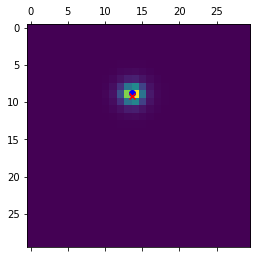

In [36]:
plt.matshow(test_image[0, 0].cpu())
plt.scatter(test_star['locs'][0, :, 1] * slen - 0.5, 
            test_star['locs'][0, :, 0] * slen - 0.5, color = 'blue')

plt.scatter(locs.cpu()[0, :, 1] * slen - 0.5, 
            locs.cpu()[0, :, 0] * slen - 0.5, color = 'red', marker = 'x')


In [37]:
# test n_sources and locs
assert n_sources == test_star["n_sources"].to(device)

In [38]:
n_sources

tensor([1.], device='cuda:0')

In [39]:
diff_locs = test_star["locs"].sort(1)[0].to(device) - locs.sort(1)[0]
diff_locs *= test_image.size(-1)
print(diff_locs)
assert diff_locs.abs().max() <= 0.5



tensor([[[-0.3545, -0.0414]]], device='cuda:0')


In [40]:
# test fluxes
diff = test_star["log_fluxes"].sort(1)[0].to(device) - log_fluxes.sort(1)[0]
assert torch.all(diff.abs() <= log_fluxes.sort(1)[0].abs() * 0.10)
assert torch.all(
    diff.abs() <= test_star["log_fluxes"].sort(1)[0].abs().to(device) * 0.10
)